In [1]:
import os
import torch
import matplotlib.pyplot as plt
import random
from torch import nn
import numpy as np
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from tqdm import tqdm

In [2]:
data_root_dir = '../datasets'

In [3]:
train_transform = transforms.Compose([transforms.ToTensor(),])
test_transform = transforms.Compose([transforms.ToTensor(),])
train_dataset = MNIST(data_root_dir, train=True,  download=True, transform=train_transform)
test_dataset  = MNIST(data_root_dir, train=False, download=True, transform=test_transform)

In [4]:
class Autoencoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()
        
        ### Encoder
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 64),
            nn.ReLU(True),
            nn.Linear(64, encoded_space_dim)
        )
        
        ### Decoder
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 64),
            nn.ReLU(True),
            nn.Linear(64, 3 * 3 * 32),
            nn.ReLU(True)
        )
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )

    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

    def encode(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = x.view([x.size(0), -1])
        # Apply linear layers
        x = self.encoder_lin(x)
        return x
    
    def decode(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Reshape
        x = x.view([-1, 32, 3, 3])
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [5]:
#%% Prepare training

### Define dataloader
train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=512, shuffle=False)


device = torch.device("cpu")
# Move all the network parameters to the selected device (if they are already on that device nothing happens)


In [6]:
#%% Network training

### Training function
def train_epoch(net, dataloader, loss_fn, optimizer):
    # Training
    net.train()
    loss_to_save=[]
    for sample_batch in dataloader:
        # Extract data and move tensors to the selected device
        image_batch = sample_batch[0].to(device)
        # Forward pass
        output = net(image_batch)
        loss = loss_fn(output, image_batch)
        loss_to_save.append(loss)
        # Backward pass
        optim.zero_grad()
        loss.backward()
        optim.step()
        # Print loss
        #print('\t partial train loss: %f' % (loss.data))
    return loss_to_save


### Testing function
def test_epoch(net, dataloader, loss_fn, optimizer):
    # Validation
    net.eval() # Evaluation mode (e.g. disable dropout)
    with torch.no_grad(): # No need to track the gradients
        conc_out = torch.Tensor().float()
        conc_label = torch.Tensor().float()
        for sample_batch in dataloader:
            # Extract data and move tensors to the selected device
            image_batch = sample_batch[0].to(device)
            # Forward pass
            out = net(image_batch)
            # Concatenate with previous outputs
            conc_out = torch.cat([conc_out, out.cpu()])
            conc_label = torch.cat([conc_label, image_batch.cpu()]) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

def Evaluation(net,dataset,loss_fn):
    net.eval()
    loss_test=[]
    i=0
    for image in dataset:
            img = image[0].unsqueeze(0).to(device)
            with torch.no_grad():
                out = net(img)
                loss = loss_fn(out, img)
                loss_test.append(loss)
                #plt.figure(figsize=(12,10))
                #plt.imshow(out.squeeze().numpy(), cmap='gist_gray')
                #plt.show()
    return loss_test
    

## Research of lr

In [7]:
training = True
num_epochs = 40

### Define a loss function
loss_fn = torch.nn.MSELoss()

learning_rate = [1e-2,5e-3,1e-3,5e-4,1e-5]



if training:
    list_of_dict_lr=[]
    for lr in tqdm(learning_rate):
        net = Autoencoder(encoded_space_dim=6)
        net.to(device)
        optim = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=1e-5)
        validation_loss=[]
        for epoch in range(num_epochs):
            loss_iter= train_epoch(net, dataloader=train_dataloader, loss_fn=loss_fn, optimizer=optim)
            val_loss = test_epoch(net, dataloader=test_dataloader, loss_fn=loss_fn, optimizer=optim)
            validation_loss.append(val_loss)
            
        loss_test= Evaluation(net,test_dataset,loss_fn=loss_fn)
            
        list_of_dict_lr.append({"lr":lr,"val_loss":validation_loss,"test_loss":loss_test})





100%|██████████| 5/5 [1:49:40<00:00, 1377.19s/it]  


loss on test:  0.022195958
loss on test:  0.021874474
loss on test:  0.021962686
loss on test:  0.024907593
loss on test:  0.0733927


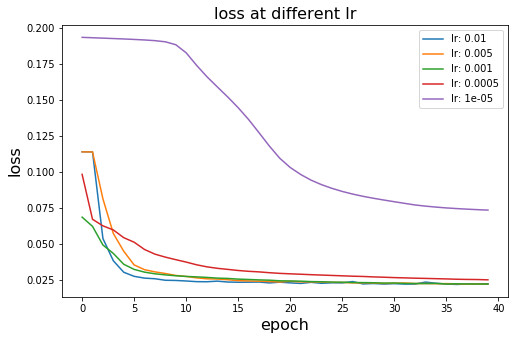

In [17]:
plt.figure(figsize=(8,5))
for i in list_of_dict_lr:
    plt.plot(i["val_loss"],label="lr: "+str(i["lr"]))
    print("loss on test: ",np.mean(i["test_loss"]))

plt.title("loss at different lr",fontsize=16)
plt.xlabel("epoch",fontsize=16)
plt.ylabel("loss",fontsize=16)
plt.legend()
plt.savefig("loss_tuning_lr.pdf")
plt.show()


## Research of encoded dimension

In [9]:
training = True
num_epochs = 40
loss_fn = torch.nn.MSELoss()
lr=0.05
encoded_space_dim = [2,4,6,8,10]


if training:
    list_of_dict_dim=[]
    for end_dim in tqdm(encoded_space_dim):
        print(end_dim)
        net = Autoencoder(encoded_space_dim=end_dim)
        net.to(device)
        optim = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=1e-5)
        validation_loss=[]
        for epoch in range(num_epochs):
            loss_iter= train_epoch(net, dataloader=train_dataloader, loss_fn=loss_fn, optimizer=optim)
            val_loss = test_epoch(net, dataloader=test_dataloader, loss_fn=loss_fn, optimizer=optim)
            validation_loss.append(val_loss)
             
        #valuto la net nel test set            
        loss_test= Evaluation(net,test_dataset,loss_fn=loss_fn)
            
        list_of_dict_dim.append({"dim":end_dim,"val_loss":validation_loss,"loss_test":loss_test})



  0%|          | 0/5 [00:00<?, ?it/s]

2


 20%|██        | 1/5 [17:12<1:08:51, 1032.96s/it]

4


 40%|████      | 2/5 [33:56<51:12, 1024.15s/it]  

6


 60%|██████    | 3/5 [51:38<34:31, 1035.62s/it]

8


 80%|████████  | 4/5 [1:10:16<17:40, 1060.18s/it]

10


100%|██████████| 5/5 [1:31:38<00:00, 1126.83s/it]


loss on test:  0.043550465
loss on test:  0.067683645
loss on test:  0.030046176
loss on test:  0.06779353
loss on test:  0.06769314


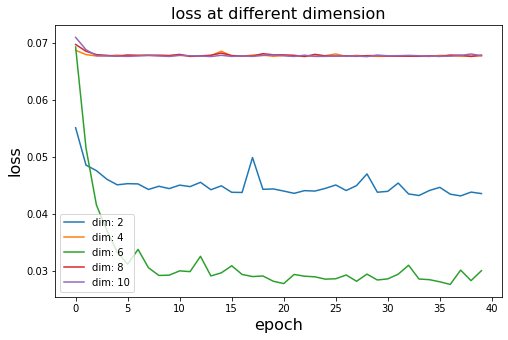

In [19]:
plt.figure(figsize=(8,5))
for i in list_of_dict_dim:
    plt.plot(i["val_loss"],label="dim: "+str(i["dim"]))
    print("loss on test: ",np.mean(i["loss_test"]))
    
plt.title("loss at different dimension",fontsize=16)
plt.xlabel("epoch",fontsize=16)
plt.ylabel("loss",fontsize=16)
plt.legend()
plt.savefig("loss_tuning_dim.pdf")
plt.show()

## Best model

In [25]:
training = True
num_epochs = 7
loss_fn = torch.nn.MSELoss()
lr=0.01
encoded_space_dim = 4
net = Autoencoder(encoded_space_dim=encoded_space_dim)
net.to(device)


if training:
    optim = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=1e-5)
    validation_loss=[]
    training_loss=[]
    for epoch in range(num_epochs):
        loss_iter= train_epoch(net, dataloader=train_dataloader, loss_fn=loss_fn, optimizer=optim)
        training_loss.append(loss_iter[-1])
        val_loss = test_epoch(net, dataloader=test_dataloader, loss_fn=loss_fn, optimizer=optim)
        validation_loss.append(val_loss)
          
    loss_test= Evaluation(net,test_dataset,loss_fn=loss_fn)
    torch.save(net.state_dict(), 'net_params_best_model.pth')
    







  0%|          | 0/1000 [00:00<?, ?it/s]


  8%|▊         | 84/1000 [00:00<00:01, 837.09it/s]


 17%|█▋        | 171/1000 [00:00<00:00, 846.38it/s]


 26%|██▌       | 256/1000 [00:00<00:00, 845.55it/s]


 33%|███▎      | 333/1000 [00:00<00:00, 821.34it/s]


 42%|████▏     | 418/1000 [00:00<00:00, 829.41it/s]


 49%|████▉     | 492/1000 [00:00<00:00, 797.06it/s]


 56%|█████▋    | 565/1000 [00:00<00:00, 774.97it/s]


 64%|██████▎   | 636/1000 [00:00<00:00, 752.18it/s]


 71%|███████   | 707/1000 [00:00<00:00, 726.34it/s]


 78%|███████▊  | 777/1000 [00:01<00:00, 716.99it/s]


 85%|████████▍ | 847/1000 [00:01<00:00, 679.42it/s]


 91%|█████████▏| 914/1000 [00:01<00:00, 509.86it/s]


 98%|█████████▊| 978/1000 [00:01<00:00, 541.08it/s]


100%|██████████| 1000/1000 [00:01<00:00, 677.14it/s]

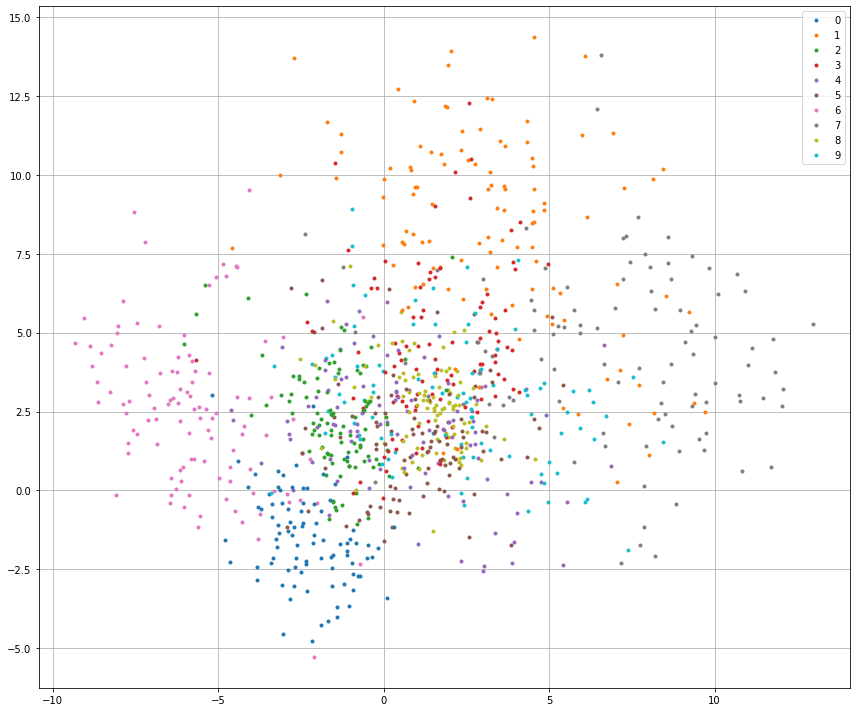

In [27]:
#%% Network analysis


net = Autoencoder(encoded_space_dim=encoded_space_dim)
net.load_state_dict(torch.load('net_params_best_model.pth', map_location='cpu'))   

### Get the encoded representation of the test samples
encoded_samples = []
for sample in test_dataset:
    img = sample[0].unsqueeze(0)
    label = sample[1]
    # Encode image
    net.eval()
    with torch.no_grad():
        encoded_img  = net.encode(img)
    # Append to list
    encoded_samples.append((encoded_img.flatten().numpy(), label))
    

### Visualize encoded space
color_map = {
        0: '#1f77b4',
        1: '#ff7f0e',
        2: '#2ca02c',
        3: '#d62728',
        4: '#9467bd',
        5: '#8c564b',
        6: '#e377c2',
        7: '#7f7f7f',
        8: '#bcbd22',
        9: '#17becf'
        }
    
# Plot just 1k points
encoded_samples_reduced = random.sample(encoded_samples, 1000)
plt.figure(figsize=(12,10))
for enc_sample, label in tqdm(encoded_samples_reduced):
    plt.plot(enc_sample[0], enc_sample[1], marker='.', color=color_map[label])
plt.grid(True)
plt.legend([plt.Line2D([0], [0], ls='', marker='.', color=c, label=l) for l, c in color_map.items()], color_map.keys())
plt.tight_layout()
plt.show()
